In [54]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit import Aer, assemble
from qiskit import ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import library for manipulating dictionary in python
import collections

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-03-12 07:08:32,615: Credentials are already in use. The existing account in the session will be replaced.


In [55]:
# function to apply Hadamard gates to chosen qubits in a circuit qc

def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc


# function to apply Oracle that returns circuit qc with phase (-1) applied to the solution state only

def f_oracle(dset, qc):
    
    # we use qubits 0, 1 to encode states corresponding to different solutions: |01> if number_1 > number_2, and |10> if number_1 < number_2
    
    # qubit 2 is the ancilla, which will be left unchanged, in state |0>
    
    f_arr = np.zeros(4) # function that determines the phase to be added to the states |00>, |01>, |10>, |11> depending on the maximum; f(x) = 1 for x = solution, otherwise f(x) = 0
    ind = 0
    for i in range(0, 2):
        for j in range(0, 2):
            temp = dset[i]-dset[j]

            if temp == 0:
                val = 0
            else:
                val = np.floor((temp/np.abs(temp) + 1)/2)
            f_arr[ind] = val
            ind += 1
            
    if f_arr[0] == 1: # if |00> is solution state
        qc.x(0)
        qc.x(1)
    elif f_arr[1] == 1: # if |01> is solution state
        qc.x(0)
    elif f_arr[2] == 1: # if |10> is solution state
        qc.x(1)
        
    qc.ccx(0,1,2)
    qc.z(2) 
    qc.ccx(0,1,2) 
    
    if f_arr[0] == 1:
        qc.x(0)
        qc.x(1)
    elif f_arr[1] == 1:
        qc.x(0)
    elif f_arr[2] == 1:
        qc.x(1)

        
    return qc



In [58]:
def find_the_largest_number(number_1, number_2):
    
    # quantum circuit of 3 qubits
    
    n = 3
    qc = QuantumCircuit(n)
    
    # apply H to qubits 0, 1
    
    qc = initialize_s(qc, [0,1])
    
    # make a list from the two numbers
    
    dset = [number_1, number_2]
    
    # apply oracle: marks the solution state with a phase (-1)
    
    qc = f_oracle(dset, qc)
    
    # apply H to qubits 0, 1
    
    qc = initialize_s(qc, [0,1])
    
    
    # mark the |00> state with a phase (-1)

    qc.x(0)
    qc.x(1)

    qc.ccx(0,1,2) 
    qc.z(2) 
    qc.ccx(0,1,2) 

    qc.x(0)
    qc.x(1)
    
    # apply H to qubits 0, 1

    qc = initialize_s(qc, [0,1])
    
    # measure all qubits to get final state
    
    qc.measure_all()
    
    # qc.draw() # optional, can be used to draw quantum circuit if desired
    
    
    # get probability (counts) of measuring a state using a backend simulator
    
    aer_sim = Aer.get_backend('aer_simulator')
    qobj = assemble(qc)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts()

    counts = collections.defaultdict(lambda : 0, counts) 
    
    # the state for which counts are the greatest points to the solution
    
    if counts['010'] > 0:
        return [dset[0], qc]
    else:  # since the only other solution state is '100', counts must be non-zero for it
        return [dset[1], qc]

In [60]:
# test code for any two numbers (not just integers) as the code does not depend on the type of number used (integer, rational, irrational)

find_the_largest_number(0.5,-463)[0]

0.5

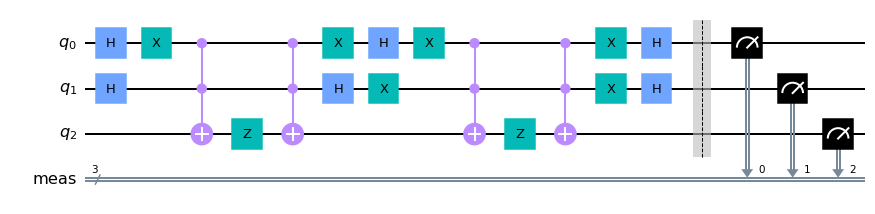

In [61]:
find_the_largest_number(0.5,-463)[1].draw()